# interpret cell state

In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
mpl.rcParams['figure.dpi'] = 150

import sys
sys.path.append("/home/tommy/ml_drought")

In [2]:
[k for k in list(plt.rcParams.keys()) if "size" in k]

label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)
# plt.rcParams["font.size"]

In [3]:
from torch.utils.data import DataLoader
from ruamel.yaml import YAML

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
%load_ext autoreload
%autoreload 2

# Load in all of the raw data (original)

In [6]:
# all_data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

dynamic['station_id'] = dynamic['station_id'].astype(int)

catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]

## Extra Processes

In [7]:
# Get the list of basins that we actually have results for
lstm_preds_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_preds_df["time"] = pd.to_datetime(lstm_preds_df["time"])
lstm_preds = lstm_preds_df.set_index(["station_id", "time"]).to_xarray()

VALID_BASINS = (lstm_preds_df["station_id"].unique())

In [8]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Load in the Cell State Data

In [9]:
def replace_basin_list_with_full_filepath(config_file: Path):
    import fileinput

    filename = config_file.as_posix()
    text_to_search = "data/camels_gb_basin_list.txt"
    replacement_text = "/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt"
    with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace(text_to_search, replacement_text), end='')

# [replace_basin_list_with_full_filepath(p) for p in (data_dir / "runs/ensemble").glob("*/config.yml")]

In [10]:
from scripts.drafts.cell_state_extract import (load_config_file, load_ealstm, load_lstm, load_normalised_cs_data, normalize_xr_by_basin)
from scripts.drafts.gb_sm_data import (read_gb_sm_data)

In [11]:
ealstm_run_dir = data_dir / "runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601"
ealstm_config = load_config_file(ealstm_run_dir)
ealstm_model = load_ealstm(ealstm_config)

lstm_run_dirs = [d for d in (data_dir / "runs/ensemble").glob("lstm_ensemble*")]
lstm_run_dirs = sorted(lstm_run_dirs)
lstm_configs = [load_config_file(d) for d in (data_dir / "runs/ensemble").glob("lstm_ensemble*")]
lstm_models = [load_lstm(c) for c in lstm_configs]

In [12]:
model = lstm_models[0]

In [13]:
model

CudaLSTM(
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Run analysis for LSTM Model

In [14]:
# ------------------
LSTM_NUMBER = 4
# ------------------

lstm_run_dir = lstm_run_dirs[LSTM_NUMBER]
config = lstm_config = lstm_configs[LSTM_NUMBER]
lstm_model = lstm_models[LSTM_NUMBER]

In [15]:
TEST_BASINS = [str(id_) for id_ in catchment_ids]
FINAL_VALUE = True
TEST_TIMES = pd.date_range(config.test_start_date, config.test_end_date, freq="D")

lstm_norm_cs_data = load_normalised_cs_data(
    config=lstm_config,
    model=lstm_model,
    test_basins=TEST_BASINS,
    test_times=TEST_TIMES,
    final_value=FINAL_VALUE,
)

# ealstm_norm_cs_data = load_normalised_cs_data(
#     config=ealstm_config,
#     model=ealstm_model,
#     test_basins=TEST_BASINS,
#     test_times=TEST_TIMES,
#     final_value=FINAL_VALUE,
# )

Normalize: 100%|██████████| 64/64 [00:00<00:00, 1177.16it/s]


# Load in SM data

In [16]:
sm_data_folder = "sm_data"  #  "GB_SM_catchments"  "sm_data"
sm = read_gb_sm_data(data_dir, sm_data_folder=sm_data_folder, save_output=False, reload_nc=False)
norm_sm = normalize_xr_by_basin(sm)

Reading SM Level: 100%|██████████| 4/4 [02:50<00:00, 42.69s/it]
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


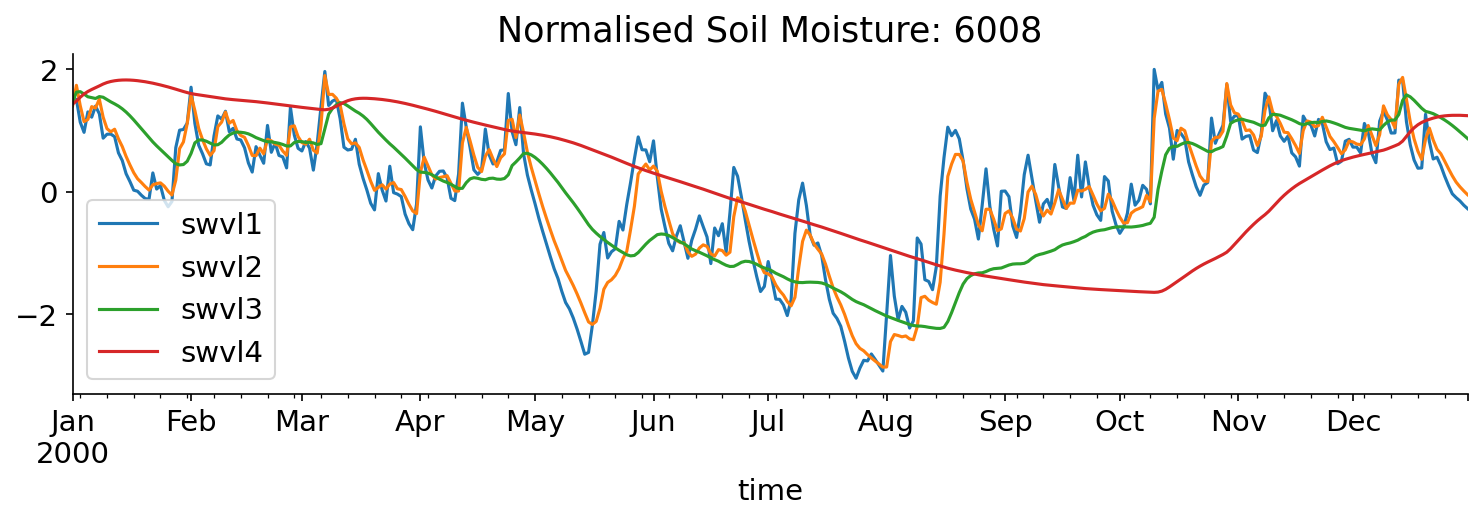

In [17]:
f, ax = plt.subplots(figsize=(12, 3))
norm_sm.isel(station_id=1).sel(time=slice("2000", "2000")).drop("station_id").to_dataframe().plot(ax=ax)
ax.set_title(f"Normalised Soil Moisture: {norm_sm.isel(station_id=10).station_id.values}")
sns.despine()

In [18]:
# lstm_norm_cs_data.sel(time=slice("2007", "2007"), dimension=0).cell_state.plot(x="time", col="station_id", col_wrap=3)
# lstm_norm_cs_data.sel(time=slice("2007", "2007"), dimension=slice(0, 65)).isel(station_id=0).cell_state.plot(x="time", col="dimension", col_wrap=3)

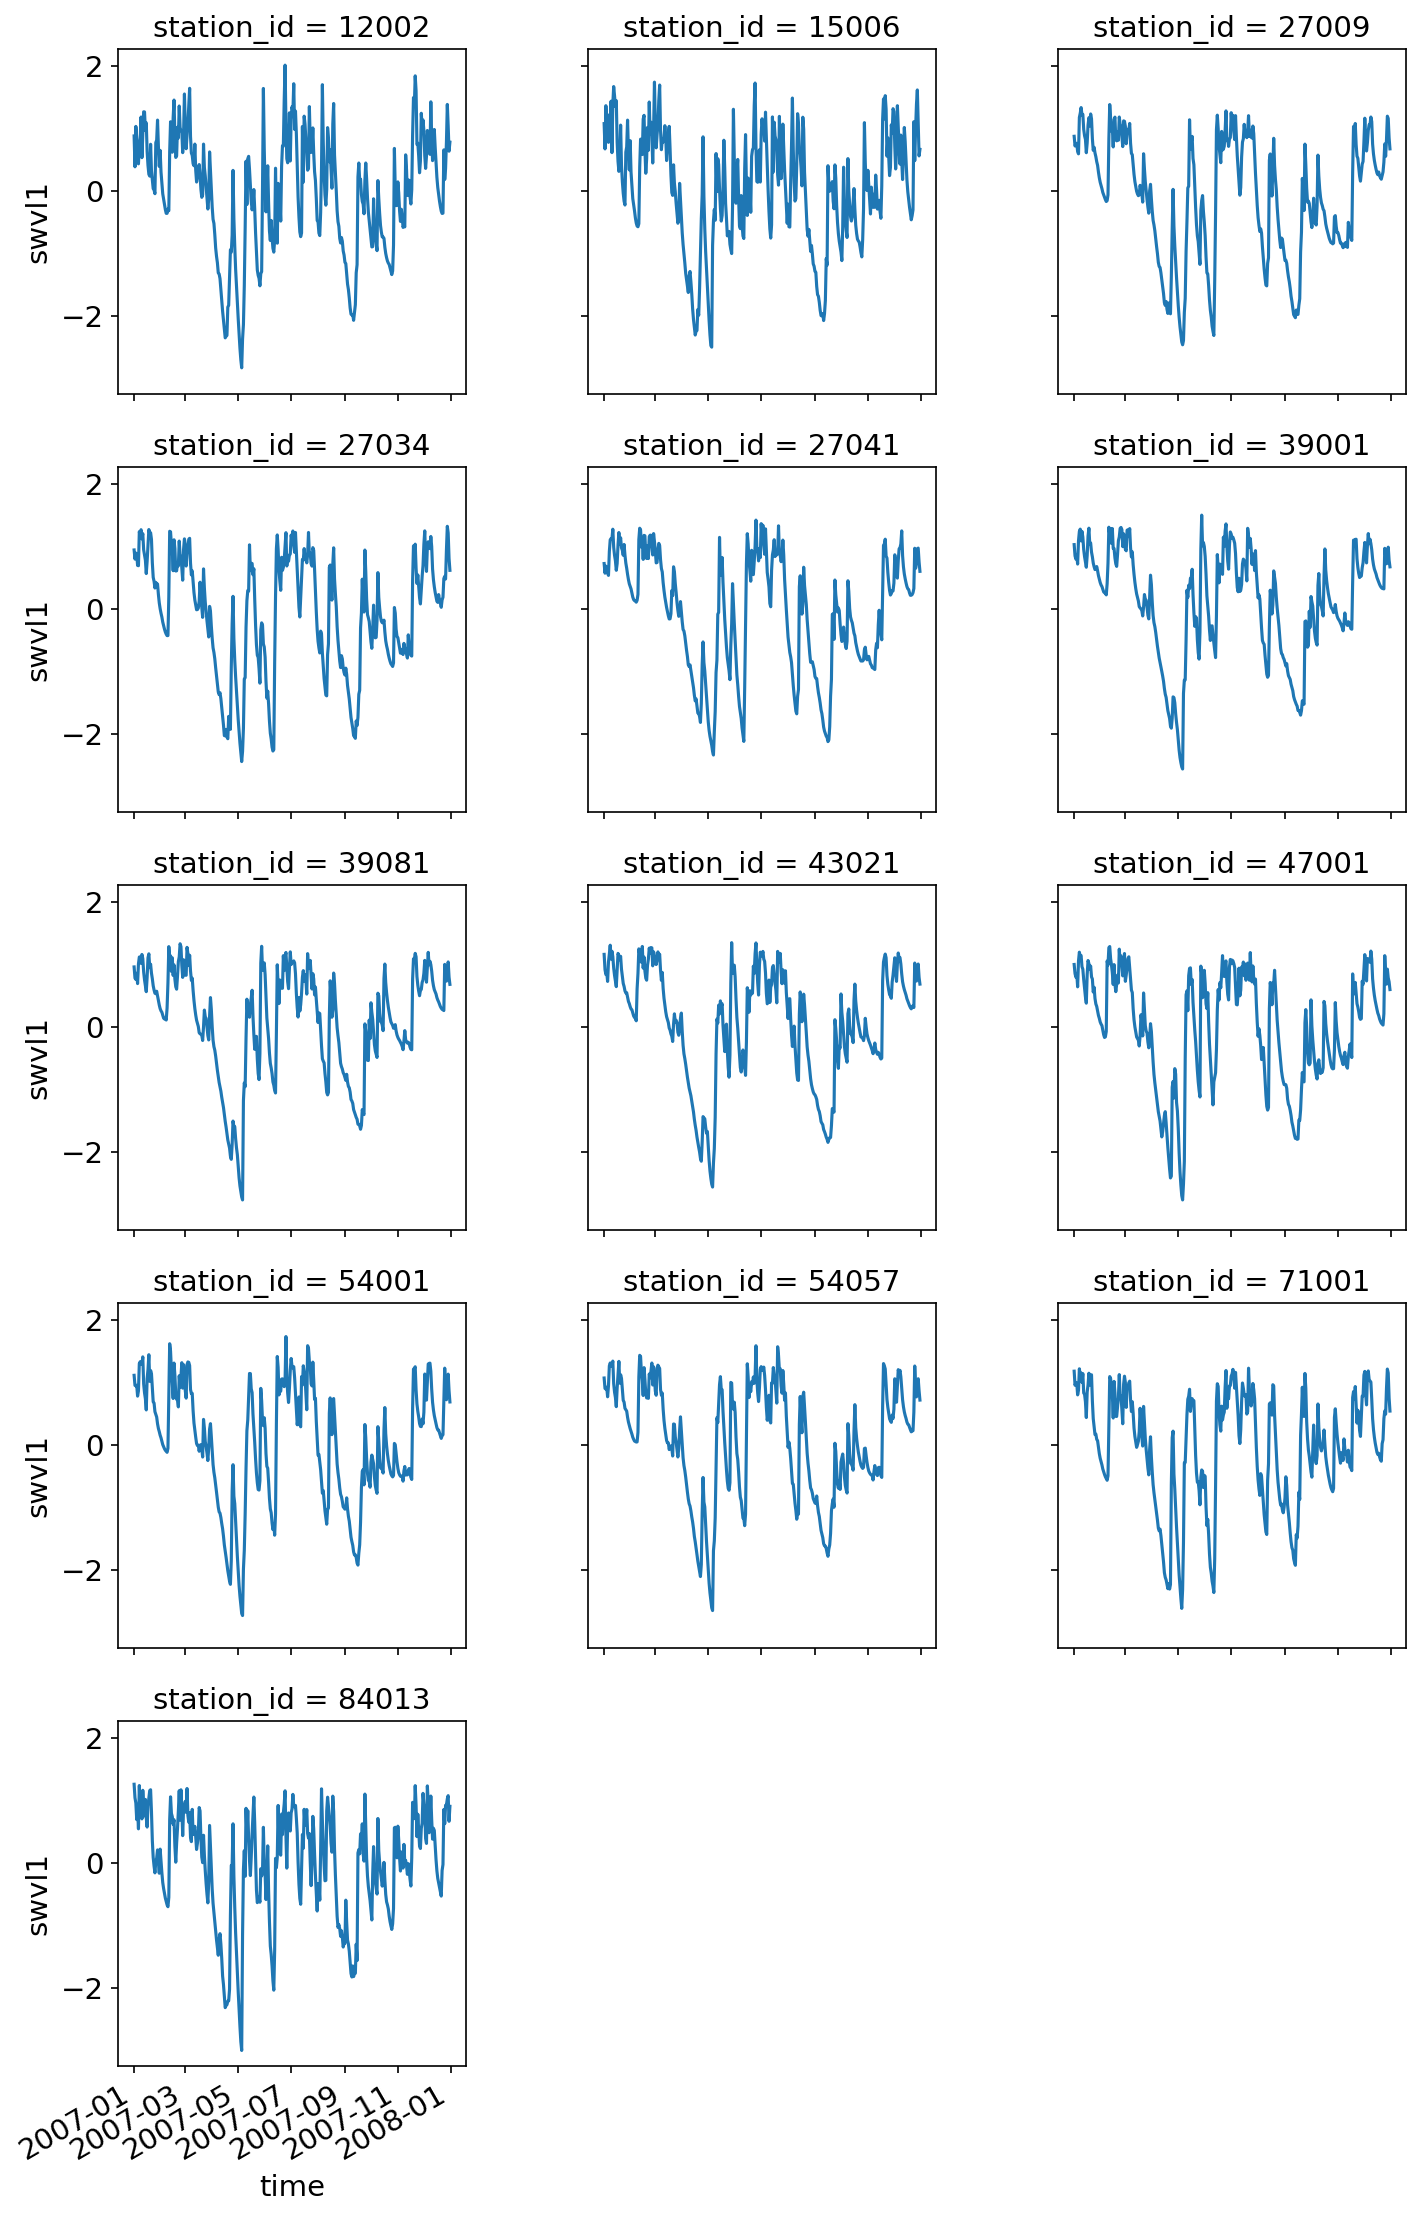

In [19]:
stations = [int(s) for s in TEST_BASINS]
norm_sm.sel(station_id=stations).swvl1.sel(time=slice("2007", "2007")).plot(x="time", col="station_id", col_wrap=3)

# Linear Regression
- CellStateDataset
- Dataloader
- train-test split 
- initialise model
- train model on each soil level
- test models on each soil level

In [20]:
from scripts.drafts.cell_state_regression import (
    run_all_soil_level_predictions,
    create_error_datasets,
    get_all_models_weights,
    train_model_loop
)

In [21]:
# train model on each soil level
train_test = True
train_val = False
losses_list = []
models = []
test_loaders = []

print("-- Training Models for Soil Levels --")
for soil_level in list(norm_sm.data_vars):
    # target data = SOIL MOISTURE
    target_data = norm_sm[soil_level]
    target_data["station_id"] = [int(sid) for sid in target_data["station_id"]]

    #  input data
    input_data = lstm_norm_cs_data
    input_data["station_id"] = [int(sid) for sid in input_data["station_id"]]

    train_losses, model, test_loader = train_model_loop(
        config=config,
        input_data=input_data,
        target_data=target_data,
        train_test=train_test,
        train_val=train_val,
        desc=soil_level,
        return_loaders=True,
    )
    # store outputs of training process
    losses_list.append(train_losses)
    models.append(model)
    test_loaders.append(test_loader)

-- Training Models for Soil Levels --


swvl4: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


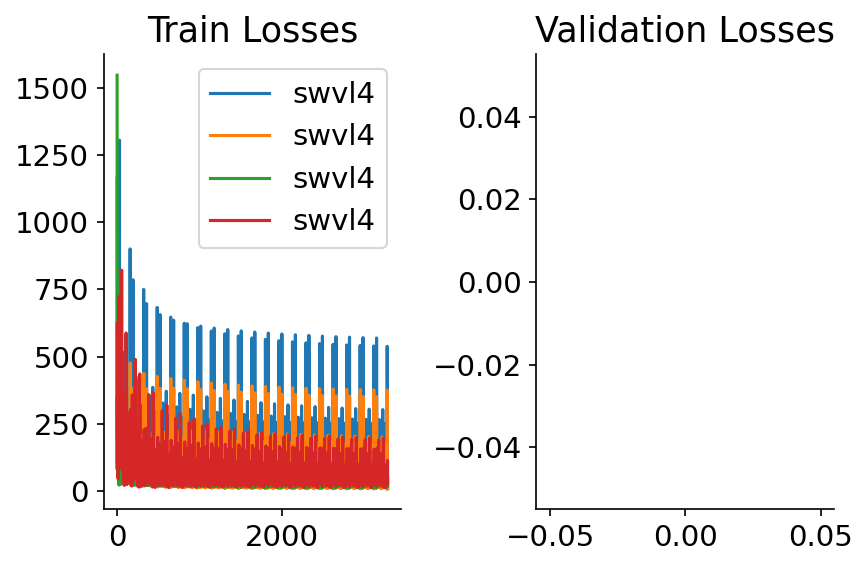

In [22]:
if "val_losses" not in globals().keys():
    val_losses = []

f, axs = plt.subplots(1, 2)
for train_losses in losses_list:
    axs[0].plot(train_losses, label=f"{soil_level}")
    axs[0].legend()
    axs[1].plot(val_losses, label=f"{soil_level}")
    axs[0].set_title("Train Losses")
    axs[1].set_title("Validation Losses")
    sns.despine()
    
plt.tight_layout()

In [23]:
# Run predictions on hold-out test set
all_preds = run_all_soil_level_predictions(
    models=models, test_loaders=test_loaders, target_data=norm_sm
)
r2s, rmses = create_error_datasets(all_preds)

MEAN R2: 0.65
MEAN STATION R2:                value
station_id          
12002       0.702438
15006       0.723173
27009       0.720314
27034       0.686540
27041       0.675671
39001       0.494119
39081       0.487966
43021       0.645232
47001       0.698910
54001       0.640986
54057       0.593604
71001       0.707632
84013       0.724989
MEAN LEVEL R2:              value
variable          
swvl1     0.679198
swvl2     0.725150
swvl3     0.667385
swvl4     0.544135


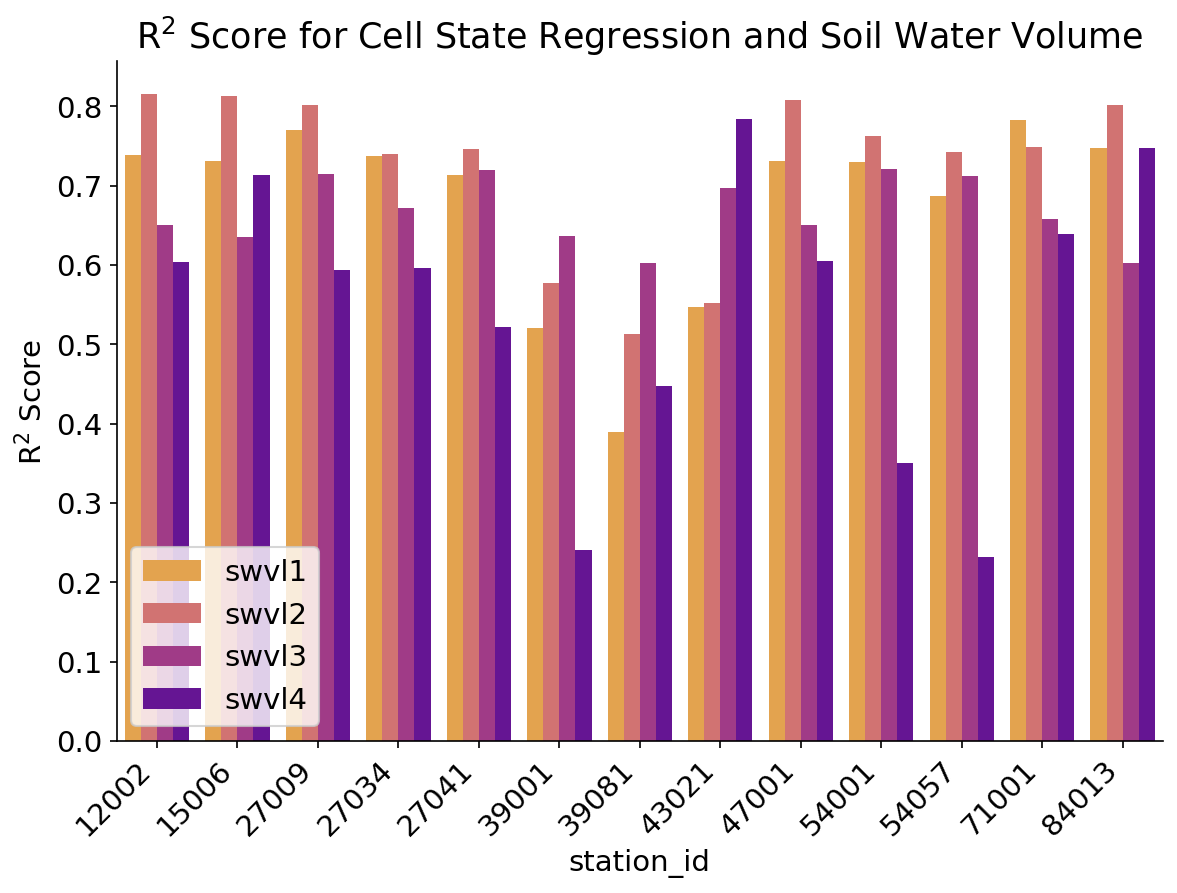

In [24]:
scale = 1.5
data = r2s.to_dataframe().reset_index().melt(id_vars="station_id").sort_values("variable")
f, ax = plt.subplots(figsize=(6 * scale, 4 * scale))

sns.barplot(x="station_id", hue="variable", y="value", data=data, palette="plasma_r", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
ax.set_title("R$^2$ Score for Cell State Regression and Soil Water Volume")
ax.set_ylabel("R$^2$ Score")
ax.legend(loc="lower left")
sns.despine()
print(f"MEAN R2: {data.drop('station_id', axis=1).mean().values[0]:.2f}")
print(f"MEAN STATION R2: {data.groupby('station_id').mean()}")
print(f"MEAN LEVEL R2: {data.groupby('variable').mean()}")

In [25]:
df = data.rename({"value": "R2"}, axis=1).set_index(["station_id", "variable"]).unstack("variable")
display(df.head())
print(df.to_latex(float_format="%.2f"))

R2                              
variable       swvl1     swvl2     swvl3     swvl4
station_id                                        
12002       0.738846  0.816073  0.651058  0.603775
15006       0.730845  0.812956  0.635214  0.713677
27009       0.770368  0.802105  0.715400  0.593382
27034       0.738011  0.740245  0.672105  0.595798
27041       0.713873  0.746873  0.719820  0.522117

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{R2} \\
variable & swvl1 & swvl2 & swvl3 & swvl4 \\
station\_id &       &       &       &       \\
\midrule
12002      &  0.74 &  0.82 &  0.65 &  0.60 \\
15006      &  0.73 &  0.81 &  0.64 &  0.71 \\
27009      &  0.77 &  0.80 &  0.72 &  0.59 \\
27034      &  0.74 &  0.74 &  0.67 &  0.60 \\
27041      &  0.71 &  0.75 &  0.72 &  0.52 \\
39001      &  0.52 &  0.58 &  0.64 &  0.24 \\
39081      &  0.39 &  0.51 &  0.60 &  0.45 \\
43021      &  0.55 &  0.55 &  0.70 &  0.78 \\
47001      &  0.73 &  0.81 &  0.65 &  0.60 \\
54001      &  0.73 &  0.76 &  0.72 &  0.35 \\
54057      &  0.69 &  0.74 &  0.71 &  0.23 \\
71001      &  0.78 &  0.75 &  0.66 &  0.64 \\
84013      &  0.75 &  0.80 &  0.60 &  0.75 \\
\bottomrule
\end{tabular}



In [26]:
assert False, "Do you want to run the whole notebook?"

AssertionError: Do you want to run the whole notebook?

# Check individual weights

In [ ]:
# get model weights
ws, bs = get_all_models_weights(models)

kwargs = {"vmin": -0.5, "vmax": 0.5, "cmap": "RdBu_r"}

f, ax = plt.subplots()
im = ax.imshow(ws.T, aspect='auto', **kwargs)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["swvl1", "swvl2", "swvl3", "swvl4"])
ax.set_title("Linear Regression Weights")
plt.colorbar(im)

In [ ]:
from scripts.drafts.cell_state_regression import calculate_raw_correlations

all_corrs = calculate_raw_correlations(norm_sm, lstm_norm_cs_data, config=config)
all_corrs.shape

In [ ]:
# get correlations
kwargs = {"vmin": -1, "vmax": 1, "cmap": "RdBu_r"}

f, ax = plt.subplots()
im = ax.imshow(all_corrs.T, aspect='auto', **kwargs)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["swvl1", "swvl2", "swvl3", "swvl4"])
ax.set_title("Raw Correlations")
plt.colorbar(im)

# Plot individual station predictions

swvl1
swvl2
swvl3
swvl4


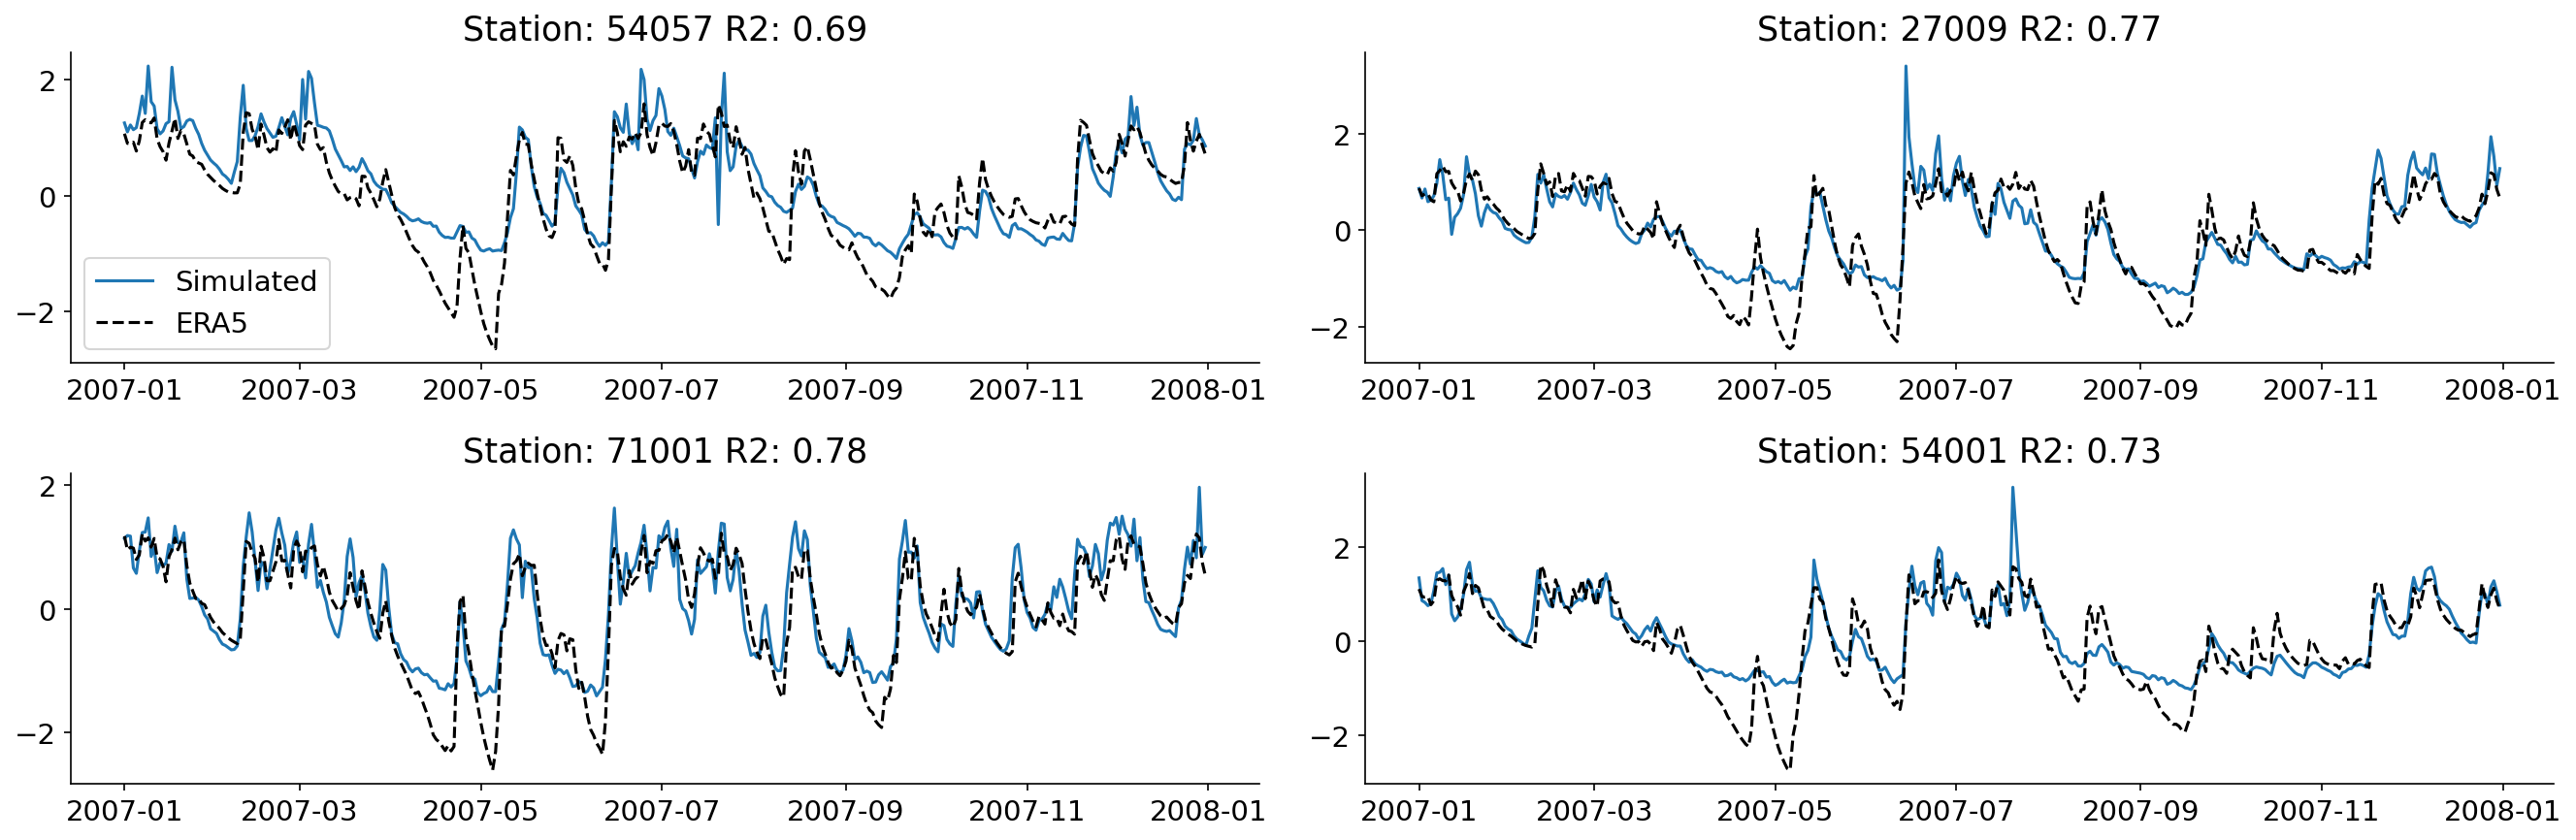

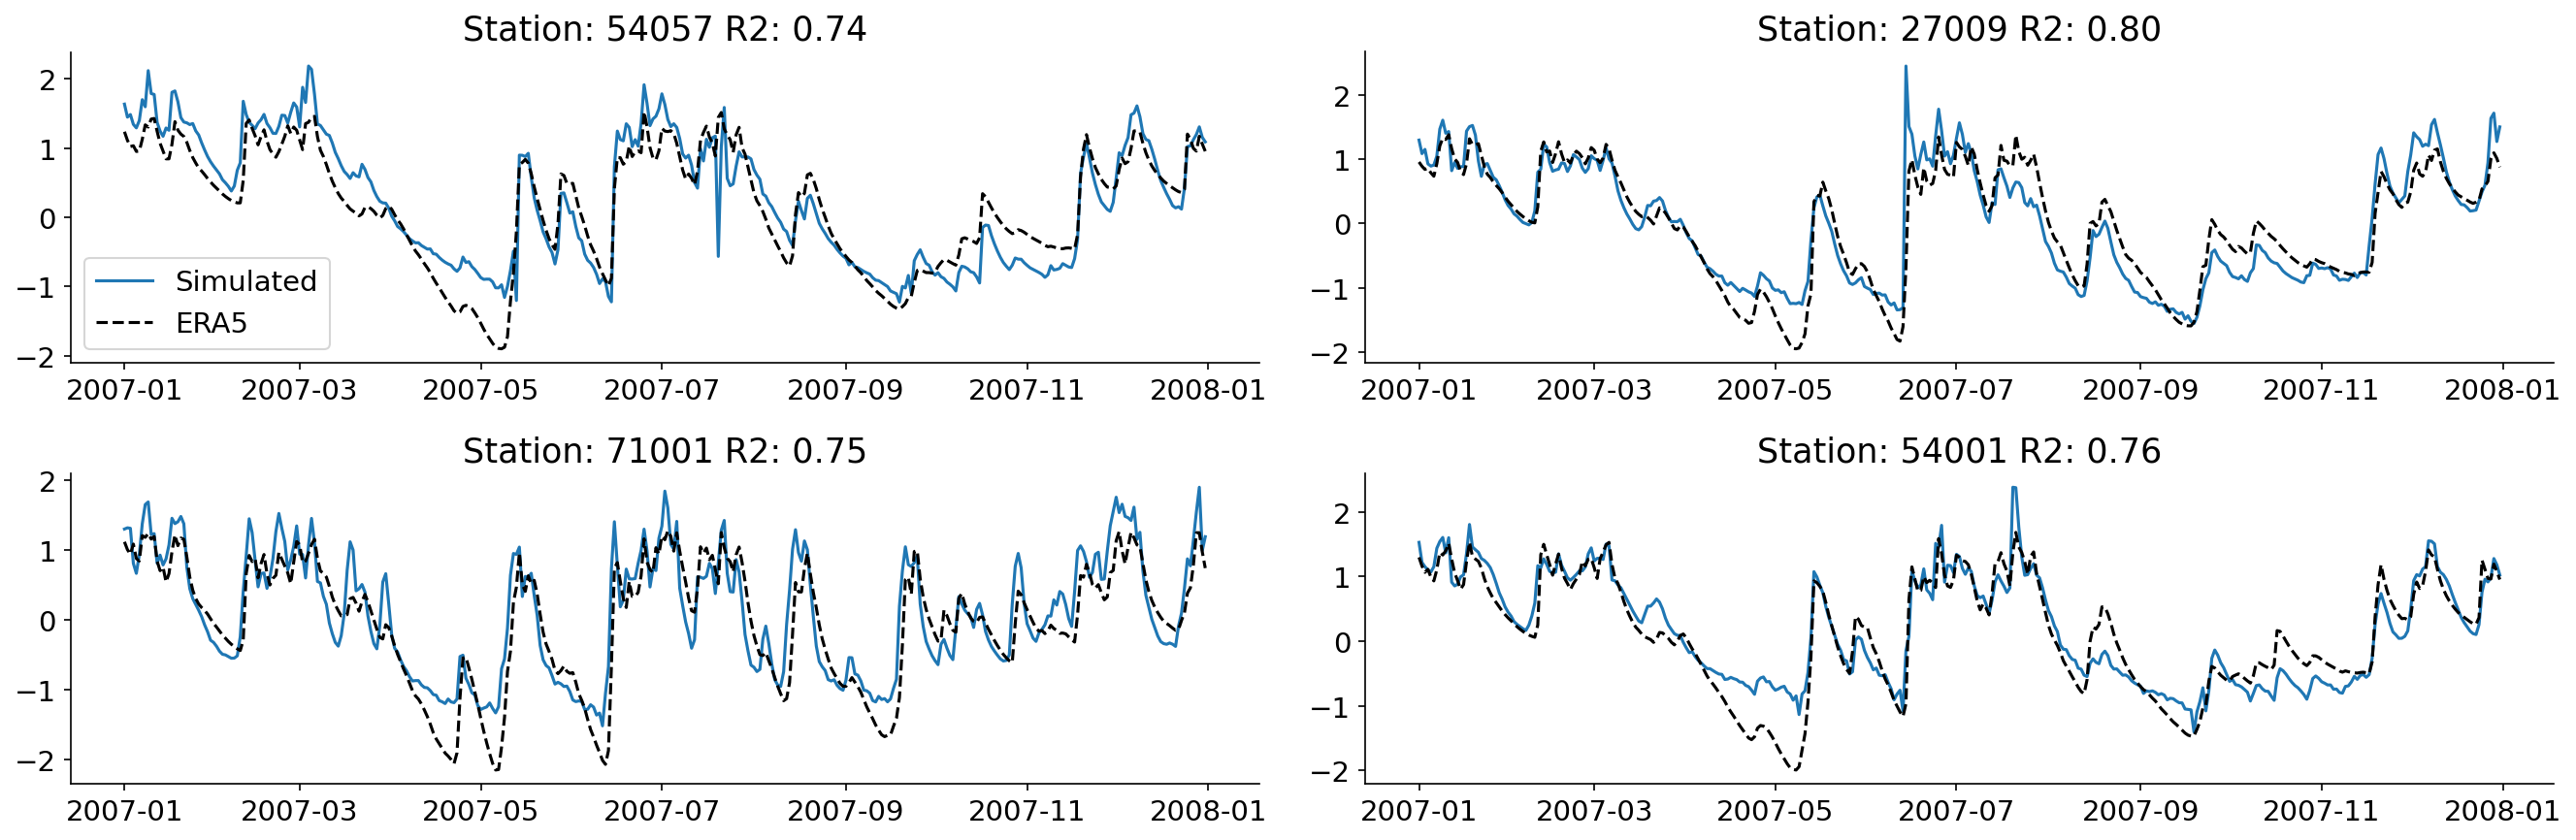

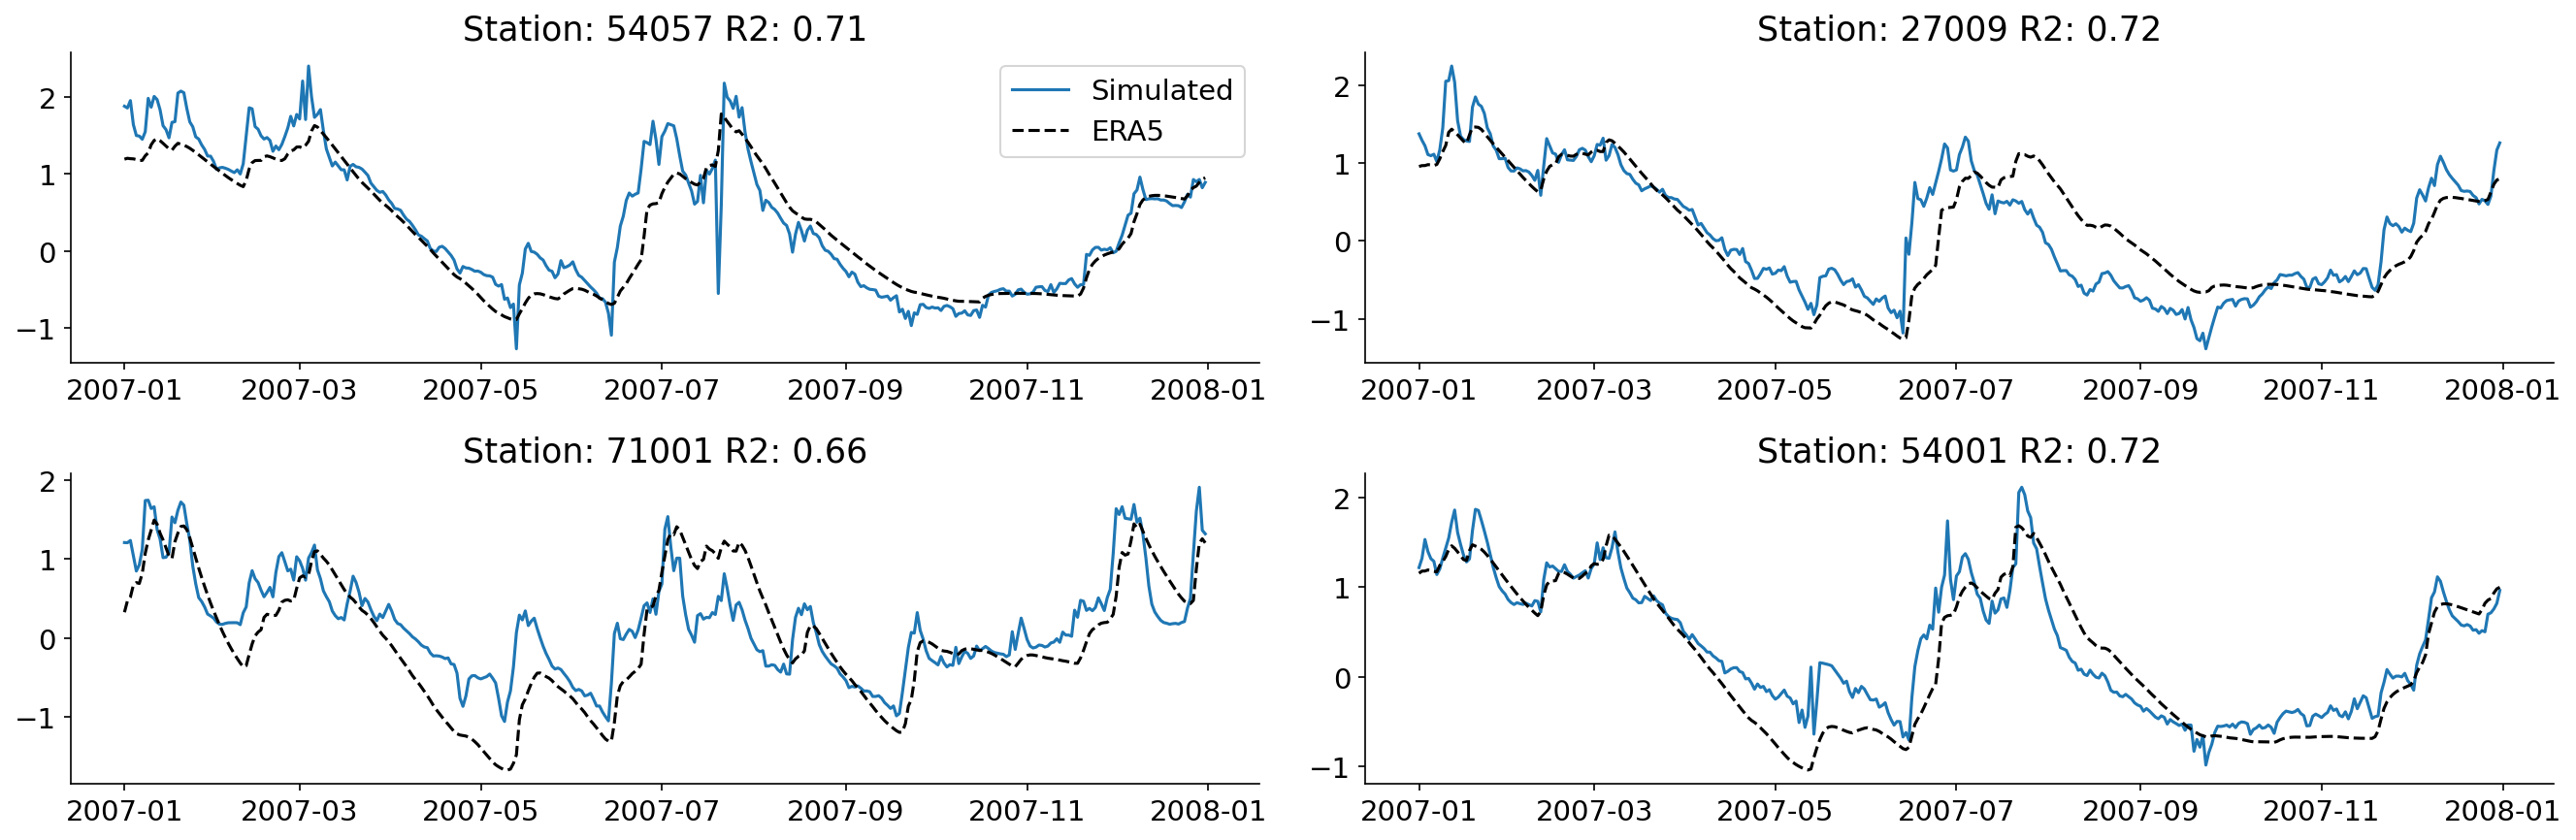

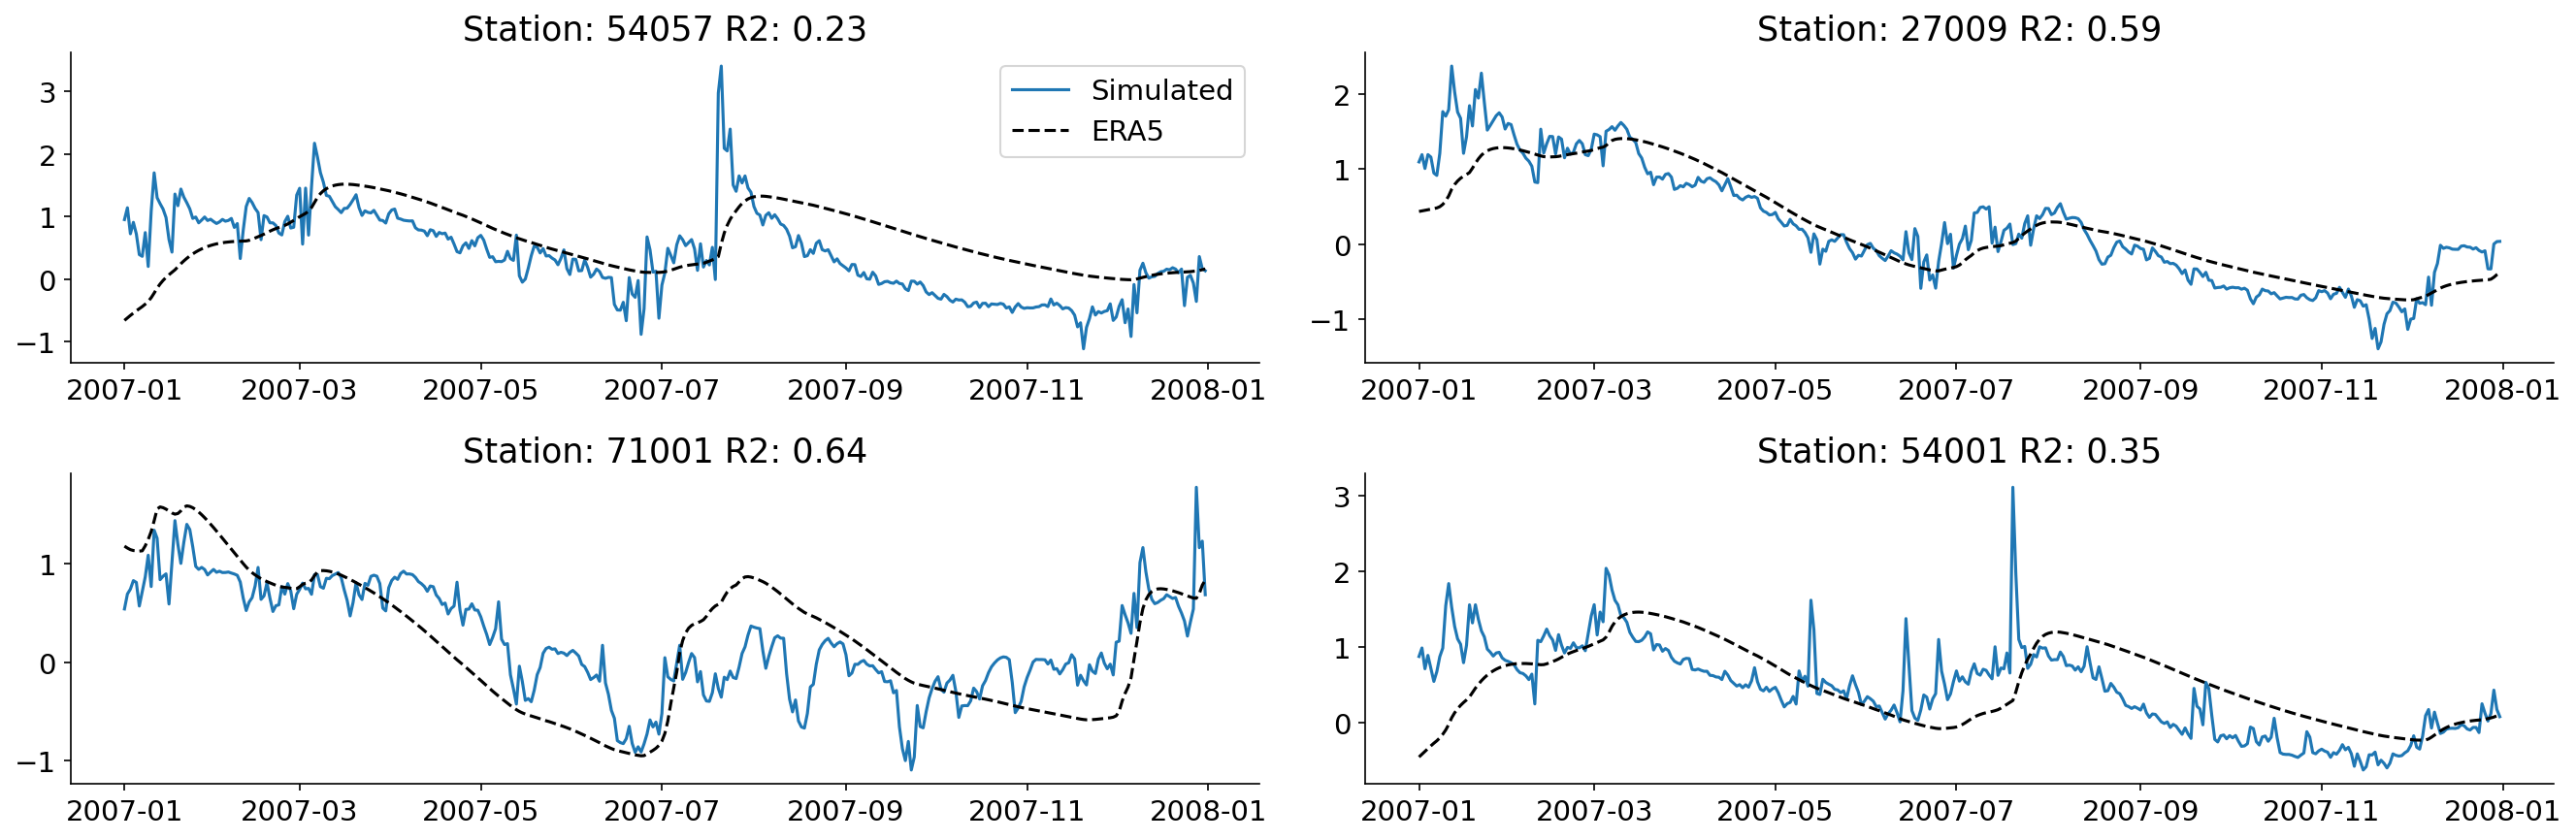

In [27]:
scale = 1.5

stations = np.random.choice([str(sid) for sid in VALID_BASINS if str(sid) != "27041"], 4, replace=False)
stations = ["54057", "27009", "71001", "54001"]
if train_test:
    year = np.random.choice([2007, 2008])
else:
    year = np.random.choice(np.unique(preds["time.year"]))

    
def plot_soil_level_regressions(layer_ix: int, year: int):
    f, axs = plt.subplots(2, 2, figsize=((6*2)*scale, (2*2)*scale))
    preds = all_preds[layer_ix]
    for ix, station in enumerate(stations):
        ax = axs[np.unravel_index(ix, (2, 2))]

        # plot the observed / sim timeseries
        d = preds.sel(station_id=station, time=slice(f"{year}", f"{year}")).to_dataframe()
        # d = d.rename({"y": f"ERA5", "y_hat": "Simulated"}, axis=1)
        if "doy" in d.columns:
            d = d.drop("doy", axis=1)
        
        ax.plot(d.index, d["y_hat"], color=sns.color_palette()[0], label="Simulated")
        ax.plot(d.index, d["y"], color="k", ls="--", label="ERA5")
        
        soil_level = f"swvl{layer_ix + 1}"
        r2 = float(r2s.sel(station_id=station)[soil_level].values)
        
        ax.set_title(f"Station: {station} R2: {r2:.2f}")
        
        ax.legend()
        if ix != 0:
            ax.get_legend().remove()

    sns.despine()
    plt.tight_layout()
    
year = 2007
for layer_ix in range(len(all_preds)):
    print(f"swvl{layer_ix + 1}")
    plot_soil_level_regressions(layer_ix=layer_ix, year=year)

# Check the climatology
 - not a fair experiment becuase only 2 years of predicted times
 - vs. 20+ years for the soil moisture data ...

In [28]:
# mean - climatology
all_obs_climatology = norm_sm.groupby("time.dayofyear").mean()
all_pred_climatology = xr.merge([ds["y_hat"].groupby("time.dayofyear").mean().rename(f"swvl{ix + 1}") for (ix, ds) in enumerate(all_preds)])
all_obs_climatology = all_obs_climatology.sel(station_id=all_pred_climatology.station_id)

# std
all_obs_climatology_std = norm_sm.groupby("time.dayofyear").std()
all_pred_climatology_std = xr.merge([ds["y_hat"].groupby("time.dayofyear").std().rename(f"swvl{ix + 1}") for (ix, ds) in enumerate(all_preds)])
all_obs_climatology_std = all_obs_climatology_std.sel(station_id=all_pred_climatology_std.station_id)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


KeyError: "not all values found in index 'station_id'"

In [ ]:
# display(all_obs_climatology_std)
# display(all_pred_climatology_std)

In [ ]:
# climatology_std.mean("station_id").to_dataframe()[:-1].plot(ax=ax)
for swl in all_pred_climatology.data_vars:
    f, ax = plt.subplots(figsize=(12, 3))
    all_obs_climatology_std[swl].mean(dim="station_id").isel().plot(label="y")
    all_pred_climatology_std[swl].mean(dim="station_id").isel().plot(label="y_hat")
    ax = plt.gca()
    ax.set_ylabel("STD")
    ax.set_title(f"{swl} Standard Deviation of Climatology")
    ax.legend()
    sns.despine()

In [ ]:
def create_mean_upper_lower_df(climatology: xr.Dataset, climatology_std: xr.Dataset, station: int, n_stds: int = 1) :
    # NOTE: dropping the final index (leap day) (`.iloc[:-1]`)
    d_std = climatology_std.sel(station_id=station).to_dataframe().iloc[:-1].drop("station_id",axis=1)
    d = climatology.sel(station_id=station).to_dataframe().iloc[:-1].drop("station_id",axis=1)
    return pd.concat([
        d,
        (d + (n_stds * d_std)).rename(dict(zip(d.columns, [f"{c}_upper" for c in d.columns])), axis=1),
        (d - (n_stds * d_std)).rename(dict(zip(d.columns, [f"{c}_lower" for c in d.columns])), axis=1),
    ], axis=1)


def get_upper_lower(climatology: xr.DataArray, climatology_std: xr.DataArray, n_stds: int = 1) -> np.ndarray:
    mean = climatology.to_dataframe().drop("station_id", axis=1)
    std = climatology_std.to_dataframe().drop("station_id", axis=1)
    upper = mean + (n_stds * std)
    lower = mean - (n_stds * std)
    return mean, upper, lower

In [ ]:
# obs_mean, obs_upper, obs_lower = get_upper_lower(swl, station, obs_mean, obs_std)
# preds_mean, preds_upper, preds_lower = get_upper_lower(swl, station, preds_mean, preds_std)

In [ ]:
obs_mean = all_obs_climatology.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station).drop("dayofyear")
obs_std = all_obs_climatology_std.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station).drop("dayofyear")
preds_mean = all_pred_climatology.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station).drop("dayofyear")
preds_std = all_pred_climatology_std.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station).drop("dayofyear")

o_mean, o_upper, o_lower = get_upper_lower(obs_mean, obs_std)
p_mean, p_upper, p_lower = get_upper_lower(preds_mean, preds_std)
o_mean

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score

plot_stds = True
std_sim = False
swl = "swvl1"

fig, axs = plt.subplots(len(climatology.station_id.values),1, figsize=(12, 2*len(climatology.station_id.values)))

for ix, station in enumerate(climatology.station_id.values):
    ax = axs[ix]
    # (DROP: the final is the leap day ...)
    obs_mean = all_obs_climatology.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station)
    obs_std = all_obs_climatology_std.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station)
    preds_mean = all_pred_climatology.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station)
    preds_std = all_pred_climatology_std.isel(dayofyear=slice(0, -1))[swl].sel(station_id=station)
    
    o_mean, o_upper, o_lower = get_upper_lower(obs_mean, obs_std)
    p_mean, p_upper, p_lower = get_upper_lower(preds_mean, preds_std)

    r2 = r2_score(o_mean, p_mean)    # d.plot(ax=ax)
    
    # Make the plots
    ax.plot(p_mean.index, p_mean, color=sns.color_palette()[0], label="y_hat")
    ax.plot(o_mean.index, o_mean, color=sns.color_palette()[1], label="y")
    if plot_stds:
        ax.fill_between(
            p_mean.index,
            p_upper[swl], p_lower[swl],
            alpha=0.2, color=sns.color_palette()[0]
        )
        ax.fill_between(
            o_mean.index,
            o_upper[swl], o_lower[swl],
            alpha=0.2, color=sns.color_palette()[1]
        )
    
    if ix == 0:
        ax.legend()
    ax.set_title(f"Station: {station} - ($R^2$: {r2:.02f})")
    ax.set_ylabel("Mean Soil Moisture")
    sns.despine()
    if ix != len(climatology.station_id.values) - 1:
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")

plt.tight_layout()

In [ ]:
print("** DONE **")

# TEST: Run regression on RAW inputs

In [ ]:
from scripts.drafts.cell_state_regression import (create_raw_input_data, train_model_loop, run_regression_each_soil_level, run_all_soil_level_predictions, create_error_datasets)

In [ ]:
raw_input_data = create_raw_input_data(
    config=config,
    target_data=norm_sm,
    basins=TEST_BASINS,
    return_as_array=False,
    with_static=False,
)
raw_input_data = raw_input_data.to_array().rename(
    {"variable": "dimension"}).rename("cell_state").to_dataset()
raw_input_data["station_id"] = [int(sid) for sid in raw_input_data["station_id"]]
norm_sm["station_id"] = [int(sid) for sid in norm_sm["station_id"]]

print("-- Training Models for Soil Levels [RAW DATA] --")
raw_losses_list, raw_models, raw_test_loaders = run_regression_each_soil_level(
    config,
    target_data=norm_sm,
    input_data=raw_input_data,
    train_test=train_test,
    train_val=train_val,
)

print("-- Running Tests on hold-out test set [RAW DATA] --")
raw_preds = run_all_soil_level_predictions(
    models=raw_models, test_loaders=raw_test_loaders, target_data=norm_sm
)

print("-- Creating Error Metrics: R2/RMSE --")
raw_r2s, raw_rmses = create_error_datasets(raw_preds)

raw_data = (
    raw_r2s.to_dataframe()
    .reset_index()
    .melt(id_vars="station_id")
    .sort_values("variable")
)
print(f"MEAN R2: {raw_data.drop('station_id', axis=1).mean().values[0]:.2f}")

In [ ]:
f, axs = plt.subplots(1, 2)
for train_losses in raw_losses_list:
    axs[0].plot(train_losses, label=f"{soil_level}")
    axs[0].legend()
    axs[1].plot(val_losses, label=f"{soil_level}")
    axs[0].set_title("Train Losses")
    axs[1].set_title("Validation Losses")
    sns.despine()

In [ ]:
f, ax = plt.subplots()
sns.barplot(x="station_id", hue="variable", y="value", data=raw_data, palette="plasma_r", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
ax.set_title("R$^2$ Score for Raw Inputs Regression and Soil Water Volume")
ax.set_ylabel("R$^2$ Score")
sns.despine()

print(f"{raw_data.drop('station_id', axis=1).mean().values[0]:.2f}")
print(f"{raw_data.groupby('station_id').mean()}")

In [ ]:
stations = np.random.choice([int(sid) for sid in raw_preds[0].station_id if str(sid) != "27041"], 4, replace=False)
if train_test:
    year = np.random.choice([2007, 2008])
else:
    year = np.random.choice(np.unique(preds["time.year"]))

for layer_ix in range(len(raw_preds)):
    f, axs = plt.subplots(2, 2, figsize=(6*2, 2*2))
    preds = raw_preds[layer_ix]
    for ix, station in enumerate(stations):
        ax = axs[np.unravel_index(ix, (2, 2))]
        # plot the observed / sim timeseries
        try:
            d = preds.sel(station_id=str(station), time=slice(f"{year}", f"{year}")).to_dataframe()
            r2 = float(r2s.sel(station_id=station)[soil_level].values)
        except KeyError:
            pass
        if "doy" in d.columns:
            d = d.drop("doy", axis=1)

        d.plot(ax=ax)
        soil_level = f"swvl{layer_ix + 1}"
        ax.set_title(f"Level {layer_ix + 1} Station: {station} R2: {r2:.2f}")
        if ix == 0:
            ax.legend()

    sns.despine()
    plt.tight_layout()